# Score Matching Introduction

Let $\mathcal{D}$ be a distribution over $\mathbb{R}^n$ with probability density function (PDF) $p: \mathbb{R}^n \to \mathbb{R}$. One way of modeling $\mathcal{D}$ is via its score function $s: \mathbb{R}^n \to \mathbb{R}^n$ defined as
$$ s(z) = \nabla_z \log p(z)$$

In practice, we may have access to $\mathcal{D}$ via a finite set of samples and don't know its PDF or score function. One simple way to produce a PDF from a discrete set of samples is via radial basis function (RBF) interpolation. For $\sigma \in \mathbb{R}^+$ define the RBF kernel as
$$ K_{\sigma}(x,z) = \textrm{exp}\left(\frac{-\lVert x-z\rVert_2^2}{2\sigma^2}\right)$$

Then the interpolated score function $s_\sigma$ for $\mathcal{D}$ is
$$ s_\sigma(z, \mathcal{D}) = \frac{\mathbb{E}_{x \sim \mathcal{D}}\left[(x-z)K_{\sigma}(x,z)\right]}{\mathbb{E}_{x \sim \mathcal{D}}\left[K_{\sigma}(x,z)\right]}$$

Given a dataset $\mathcal{D}$, the interpolated score function defines a vector field describing a soft projection of arbitrary vectors onto $\mathcal{D}$.

## Task 1: compute and display interpolated score function for a dataset

We define a simple distribution over $\mathbb{R}^2$ - uniform over a spiral - and we sample 20 points from the distribution. The task is to generate a grid of points in $\mathbb{R}^2$ and compute the interpolated score function at each point. Then call the provided plotting code to recreate the following figure:




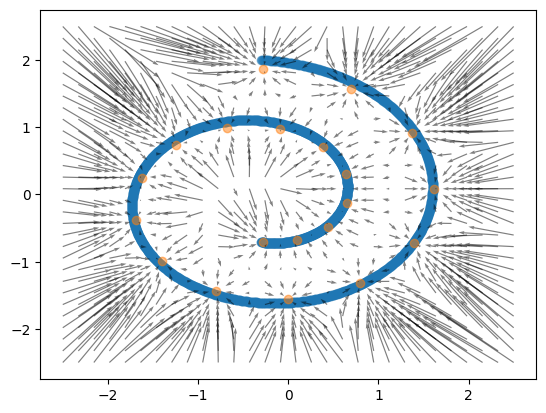


Implement the following functions:


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
# dataset generator
def spiral2d(N=100, random = False, shift=None):
    """Samples N points from a spiral centered at `shift` (or the origin if `shift` is None)"""
    time_steps = torch.rand(N) if random else torch.linspace(0, 1, N)
    t = (3 * torch.pi / 2) * (1 + 2 * time_steps)
    data = torch.stack(
        [t * torch.cos(t), t * torch.sin(t)], dim=1
    )

    data = (data - data.mean(dim=0, keepdims=True)) / data.std(dim=0, keepdims=True)

    # throw the data in a some arbitrary direction
    if shift is not None:
        data = data +  shift

    return data

# plotting helper function
def plot_vectors(z, score, **quiver_kwargs):
    """Plots vector field given by direction vectors `score` at points `z` of R^2"""
    all_lims = torch.stack((z.min(0).values, z.max(0).values, (z+score).min(0).values, (z+score).max(0).values), dim=0)
    mins = all_lims.min(0).values
    maxs = all_lims.max(0).values

    x, y = z.T
    score_x, score_y = score.T
    qargs = dict(angles='xy', scale_units='xy', scale=1, alpha=0.5)
    qargs.update(quiver_kwargs)
    plt.quiver(x, y, score_x, score_y, **qargs)

# generate and plot spiral data
true_dist = spiral2d(N=2000)
dataset = spiral2d(N=20)

In [8]:
import math
import numpy as np
import torch

def get_grid(x_lim=(-2.5,2.5), y_lim=(-2.5,2.5), nx=100, ny=100):
  """Produces an even grid of nx by ny points in R^2,
  from x_lim[0] to x_lim[1] along x axis, and y_lim[0] to y_lim[1] along y axis

  Returns tensor of shape (nx*ny, 2)
  """
  r = []
  for x in np.linspace(x_lim[0], x_lim[1], nx):
    for y in np.linspace(y_lim[0], y_lim[1], ny):
      r.append([x,y])
  return torch.tensor(r)


def rbf_score(z, data, sigma=0.2):
    """ Estimates the interpolated score function for data against inputs z
    
    Params:
    z: a tensor of shape (...,2) giving inputs to the score function
    data: a tensor of shape (N,2) giving the dataset whose interpolated score function we estimate
    sigma: the parameter of the RBF kernel
    
    Returns:
    a tensor of the same shape as z giving the interpolated score function evaluated at z
    """
    x = data
    z.shape # (1000,2)
    x.shape # (20,2)
    diff = x[:,None,:] - z # (10000,20,2)
    sq_dist = (diff**2).sum(-1) # (20,10000)
    # return -sq_dist / (2 * sigma**2)

    weight = torch.exp(-sq_dist / (2 * sigma**2)) # (20,10000)
    numer = (diff * weight[:, :, None]).mean(0) # (10000,2)
    denom = weight.mean(0)[:, None]
    score = numer / denom
    return score

    log_weight = -sq_dist / (2 * sigma**2)
    log_numer = torch.log(diff) + log_weight[:,:,None]
    return diff
    n = log_weight.shape[0]
    log_denom = torch.logsumexp(log_weight, 0) / n
    score = log_numer - log_denom[:,None]
    return log_numer
    assert not np.isnan(score).any()
    # return torch.where(numer!=0, score, 0.0)  # when weight == 0 we get 0/0., should i do this in logspace?
    
    return score


Now reproduce the plot by executing the following code:

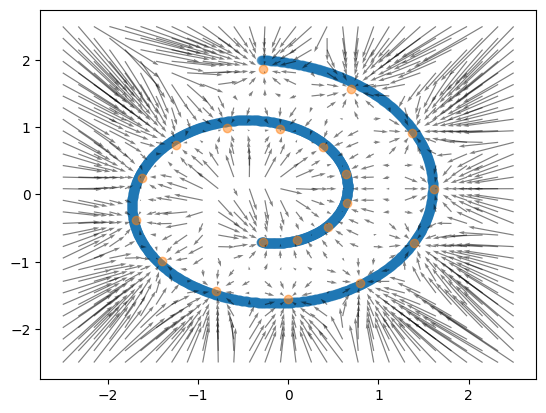

In [9]:
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)

# use solution code
grid = get_grid(nx=30,ny=30)
score = rbf_score(grid, dataset, sigma=0.2)
plot_vectors(grid.view(-1,2), score.view(-1,2), scale=2)

## Sampling via the score function

Given our interpolated score function estimate $s_\sigma$, we can now implement a sampling scheme. Specifically, we examine annealed Langevin dynamics: given $x_0$ from an arbitrary initial distribution (e.g., uniform over a grid), we define an update rule

$$
x_t = x_{t-1} + \lambda_t s_{\sigma_t}(x_{t-1}) + \sqrt{2\lambda_t}\epsilon_{t}
$$

where $\epsilon_t \sim \mathcal{N}(0,I)$ is Gaussian noise and $\lambda_t$ is an iteration-dependent step size. We anneal by taking decreasing $\sigma_t$ as $t$ increases.

We will use
- a log-linear schedule for $\sigma^2$ in $[10^{-4}, 2\times 10^{-2}]$
- $\lambda_t$ given by
$$ \lambda_t = \frac{1-\alpha_t}{\sqrt{\alpha_t(1-\bar\alpha_t)}}$$ where $\alpha = 1 - \sigma^2$ and $\bar\alpha_t = \prod^{t}_{i=1}\alpha_i$

## Task 2: Implement annealed Langevin dynamics sampler

Implement the following function:

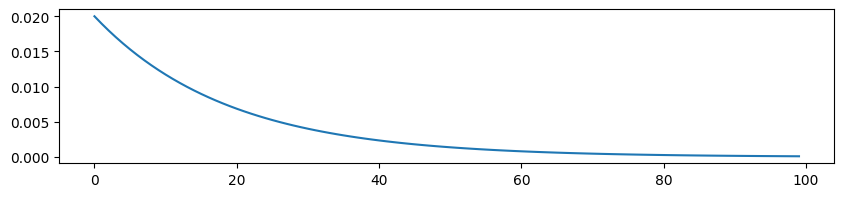

In [10]:
def log_linear_schedule(initial_value, final_value, steps):
  return torch.tensor(np.exp(np.linspace(np.log(initial_value), np.log(final_value), steps)))
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(log_linear_schedule(2e-2, 1e-4, 100))

In [12]:
def sample(init_sample, score_function, n_steps, sigma_min=1e-4, sigma_max=2e-2, return_extra=False):
  """Samples from annealed Langevin dynamics for n_steps steps

  Params:
    init_sample: a tensor of shape (...,2) giving the initial data
    score_function: a function with two parameters, x and sigma, returning the estimated interpolated score function s_sigma(x)
    n_steps: the number of steps of of the dynamics to simulate
    sigma_min: minimum sigma value for annealing
    sigma_max: maximum sigma value for annealing

  Returns:
    a list of n_steps+1 tensors, whose entries are the results of the simulation starting from init_sample (first entry is init_sample)
  """
  n, d = init_sample.shape
  sigma_sq_t = log_linear_schedule(sigma_max, sigma_min, n_steps)
  alpha_t = 1-sigma_sq_t
  alpha_t_bar = alpha_t.cumprod(0)
  lambda_t = (1-alpha_t) / torch.sqrt(alpha_t*(1-alpha_t_bar))

  path = [init_sample]
  score_terms = []
  noise_terms = []
  for i in range(n_steps):
    score_term = lambda_t[i] * score_function(path[-1], sigma_sq_t[i]**.5)
    noise_term = torch.sqrt(2*lambda_t[i])*torch.randn((n,d))
    x_curr = path[-1] + score_term + noise_term
    path.append(x_curr)
    score_terms.append(score_term)
    noise_terms.append(noise_term)
  if return_extra:
    return path, score_terms, noise_terms, lambda_t
  return path

Visualize the results:

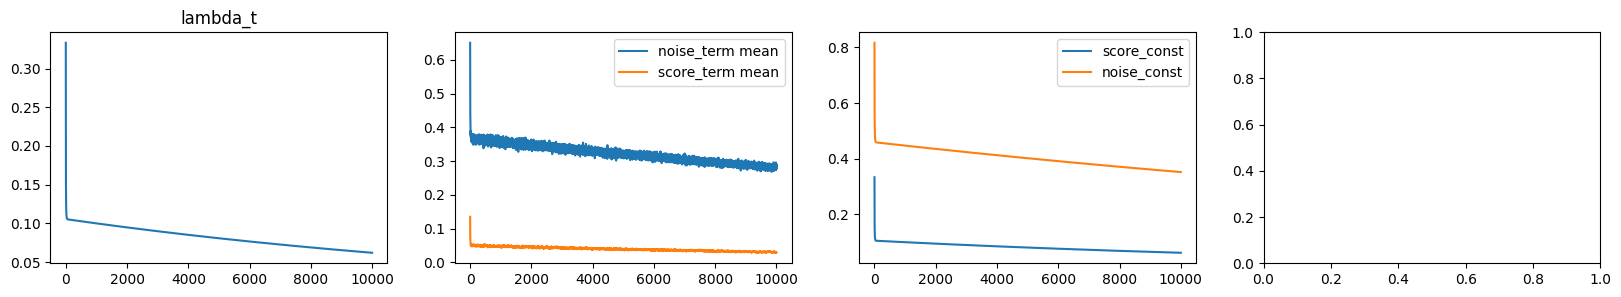

In [13]:
fig, axes = plt.subplots(1,4,figsize=(20,3))
path, score_terms, noise_terms, lambda_t = sample(grid, lambda x,sigma: rbf_score(x, dataset, sigma), n_steps=10000, sigma_min=0.06, sigma_max=0.1, return_extra=True)
axes[0].plot(lambda_t)
axes[0].set_title('lambda_t')
axes[1].plot(np.abs(np.array(noise_terms)).mean((1,2)), label='noise_term mean')
axes[1].plot(np.abs(np.array(score_terms)).mean((1,2)), label='score_term mean')
axes[1].legend()
axes[2].plot(lambda_t, label='score_const')
axes[2].plot(torch.sqrt(2*lambda_t), label='noise_const')
axes[2].legend()

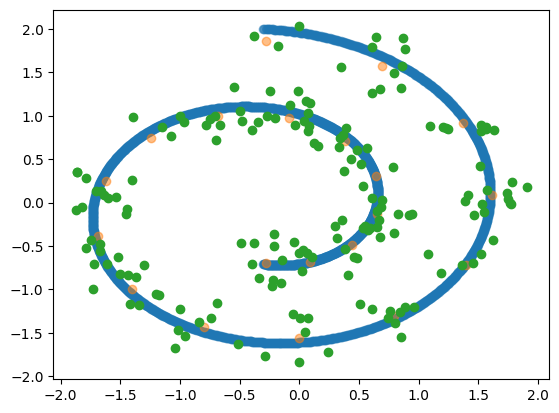

In [27]:
path = sample(grid, lambda x,sigma: rbf_score(x, dataset, sigma), n_steps=1000, sigma_min=0.0001, sigma_max=0.02)
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)
plt.scatter(*path[-1].T)

# not really sure how to interpret the nans.  if a sample gets too far away it just vanishes as the score goes to infinity...

## Simplified score matching

Instead of using the explicit expression for the interpolated score function, we could attempt to learn a score function via a simplified version of denoising score matching. Given $x \sim \mathcal{D}$, we perturb it with Gaussian noise and learn to predict the original vector $x$ (or equivalently, the perturbation). That is, we can parameterize a model $f_\theta$ with parameters $\theta$, and optimize it according to the objective

$$ \min_\theta \mathbb{E}_{x,\epsilon,\sigma}\left[\|f_\theta(x+\sigma\epsilon, \sigma)-\sigma\epsilon\|^2_2\right] $$

Here, $x \sim \mathcal{D}$ and $\epsilon \sim \mathcal{N}(0,I)$ and $\sigma$ is drawn from a log-uniform distribution corresponding to the log-linear sampling schedule.

## Task 3: Training a neural network via score matching

Define a simple neural network architecture taking as inputs the noised samples $x+\sigma\epsilon$ and the noise rate $\sigma$, and predicting $\sigma\epsilon$. Train it by optimizing the simplified denoising score matching objective.

In [41]:
from torch import nn

class NN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.GELU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(2, hidden_size),
            nn.GELU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 1)            
        )
        
    
    def forward(self, x):
        return self.model(x)


In [48]:
# ok, this looks like the simplified objective of just predicted the error

sigma = log_linear_schedule(2e-2, 1e-4, 100)
model = NN(hidden_size=8)
X = dataset
sigmas = sigma
B = X.shape[0]
for step in range(100):    
    noise = torch.randn(B,2)
    
    X_noised = X + sigma
    


RuntimeError: The size of tensor a (2) must match the size of tensor b (100) at non-singleton dimension 1

In [57]:
!poetry add einops

Configuration file exists at /Users/egafni/Library/Preferences/pypoetry, reusing this directory.

Consider moving TOML configuration files to /Users/egafni/Library/Application Support/pypoetry, as support for the legacy directory will be removed in an upcoming release.
Using version ^0.7.0 for einops

Updating dependencies
Resolving dependencies... (12.9s)Resolving dependencies... (1.5s)

Package operations: 1 install, 0 updates, 0 removals

  • Installing einops (0.7.0): Pending...
  • Installing einops (0.7.0): Downloading... 0%
  • Installing einops (0.7.0): Downloading... 100%
  • Installing einops (0.7.0): Installing...
  • Installing einops (0.7.0)

Writing lock file


In [56]:
from torch.functional import einops
(noise[:,:,None]* sigmas)

ImportError: cannot import name 'einops' from 'torch.functional' (/Users/egafni/Library/Caches/pypoetry/virtualenvs/ai-p8EyLVof-py3.11/lib/python3.11/site-packages/torch/functional.py)

In [51]:
sigma.shape

torch.Size([100])

In [ ]:
noise @ sigma

In [43]:
X

tensor([[-0.2798, -0.7010],
        [ 0.0929, -0.6831],
        [ 0.4383, -0.4844],
        [ 0.6494, -0.1297],
        [ 0.6424,  0.3059],
        [ 0.3845,  0.7120],
        [-0.0895,  0.9715],
        [-0.6795,  0.9930],
        [-1.2403,  0.7397],
        [-1.6176,  0.2464],
        [-1.6900, -0.3830],
        [-1.4049, -0.9969],
        [-0.8006, -1.4321],
        [-0.0036, -1.5575],
        [ 0.7969, -1.3113],
        [ 1.3938, -0.7241],
        [ 1.6159,  0.0820],
        [ 1.3751,  0.9179],
        [ 0.6965,  1.5719],
        [-0.2798,  1.8630]])

In [44]:
X + sigmas

tensor([0.0400, 0.0379, 0.0359, 0.0341, 0.0323, 0.0306, 0.0290, 0.0275, 0.0261,
        0.0247, 0.0234, 0.0222, 0.0210, 0.0199, 0.0189, 0.0179, 0.0170, 0.0161,
        0.0153, 0.0145, 0.0137, 0.0130, 0.0123, 0.0117, 0.0111, 0.0105, 0.0099,
        0.0094, 0.0089, 0.0085, 0.0080, 0.0076, 0.0072, 0.0068, 0.0065, 0.0061,
        0.0058, 0.0055, 0.0052, 0.0050, 0.0047, 0.0045, 0.0042, 0.0040, 0.0038,
        0.0036, 0.0034, 0.0032, 0.0031, 0.0029, 0.0028, 0.0026, 0.0025, 0.0023,
        0.0022, 0.0021, 0.0020, 0.0019, 0.0018, 0.0017, 0.0016, 0.0015, 0.0014,
        0.0014, 0.0013, 0.0012, 0.0012, 0.0011, 0.0011, 0.0010, 0.0009, 0.0009,
        0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], dtype=torch.float64)

In [46]:
sigmas.shape

torch.Size([100])

In [47]:
X.shape

torch.Size([20, 2])